### Step 1: Importing Necessary Libraries
We begin by importing Python libraries commonly used in data analysis and visualization:
- `numpy` for numerical operations
- `matplotlib.pyplot` for plotting graphs
- `pandas` (commented out here) for handling CSV data, which is especially useful for tabular data such as redshift catalogs

> Tip: If you haven’t used `pandas` before, it’s worth learning as it offers powerful tools to manipulate and analyze structured datasets.


For reading big csv files, one can use numpy as well as something called "pandas". We suggest to read pandas for CSV file reading and use that

In [1]:
 import numpy as np
 import matplotlib.pyplot as plt
 import pandas as pd
 from astropy.constants import G, c
 from astropy.cosmology import Planck18 as cosmo
 import astropy.units as u


Before we begin calculations, we define key physical constants used throughout:

- $ H_0 $: Hubble constant, describes the expansion rate of the Universe.
- $c$ : Speed of light.
-  $G$: Gravitational constant.
- $q_0$ : Deceleration parameter, used for approximate co-moving distance calculations.

We will use **`astropy.constants`** to ensure unit consistency and precision.

In [2]:
# Constants:
'''
H_0 =  # Hubble constant in SI
c =  # Speed of light in m/s
G =  # Gravitational constant in pc kg^-1 (m/s)^2

'''
q0 = -0.534  # Deceleration parameter (assumed from Planck fit KEEP it as it is)

Read the csv data into the python using the method below

In [3]:
df = pd.read_csv('Skyserver_SQL6_22_2025 6_29_58 AM.csv') # Download the data as instructed in the pdf


### 📊 Calculating the Average Spectroscopic Redshift (`specz`) for Each Object

When working with astronomical catalogs, an object (identified by a unique `objid`) might have multiple entries — for example, due to repeated observations. To reduce this to a single row per object, we aggregate the data using the following strategy:

```python
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',        # Take the mean of all spec-z values for that object
    'ra': 'first',          # Use the first RA value (assumed constant for the object)
    'dec': 'first',         # Use the first Dec value (same reason as above)
    'proj_sep': 'first'     # Use the first projected separation value
}).reset_index()


In [4]:
# Calculating the average specz for each id:
averaged_df = df.groupby('objid').agg({
    'specz': 'mean',
    'ra': 'first',
    'dec': 'first',
    'proj_sep': 'first',
}).reset_index()

averaged_df.describe()['specz']

count    6.000000
mean     0.080576
std      0.001905
min      0.077730
25%      0.079580
50%      0.080638
75%      0.081886
max      0.082918
Name: specz, dtype: float64

To create a cut in the redshift so that a cluster can be identified. We must use some logic. Most astronomers prefer anything beyond 3*sigma away from the mean to be not part of the same group. 

Find the mean, standard deviation and limits of the redshift from the data

In [5]:
mean_val = averaged_df['specz'].mean()
std_dev = averaged_df['specz'].std()
lower_limit = mean_val - 3 * std_dev
upper_limit = mean_val + 3 * std_dev

print(f"Mean redshift: {mean_val:.6f}")
print(f"Standard deviation: {std_dev:.6f}")
print(f"Redshift range for cluster members: {lower_limit:.6f} to {upper_limit:.6f}")

Mean redshift: 0.080576
Standard deviation: 0.001905
Redshift range for cluster members: 0.074862 to 0.086289


You can also use boxplot to visualize the overall values of redshift 

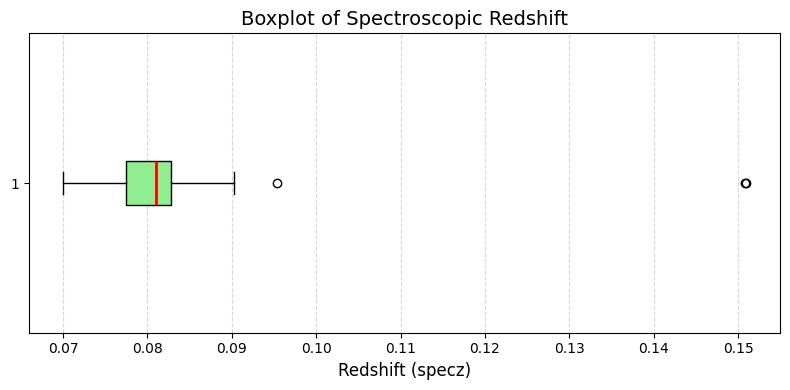

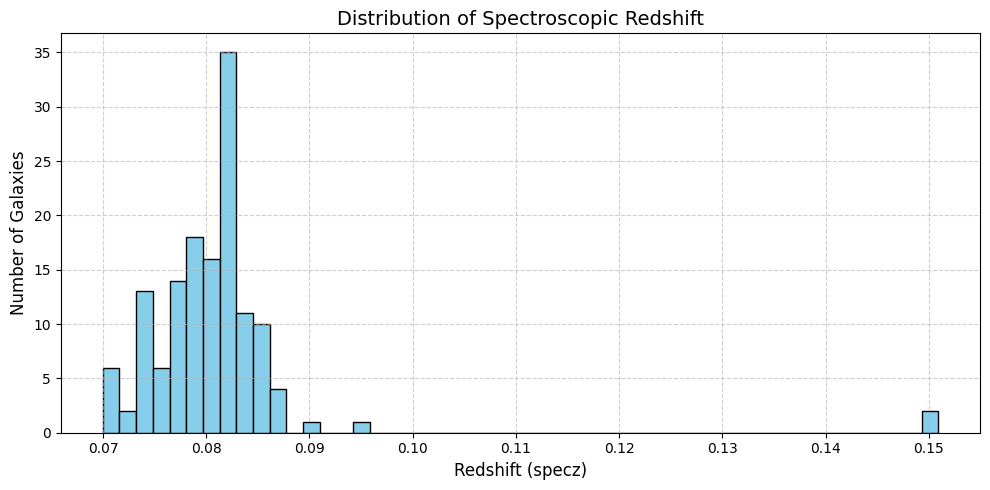

In [25]:
#boxplot
plt.figure(figsize=(8, 4))
plt.boxplot(df['specz'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red', linewidth=2))
plt.title("Boxplot of Spectroscopic Redshift", fontsize=14)
plt.xlabel("Redshift (specz)", fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
# Plot the dsitribution of redshift as histogram and a boxplot 
plt.figure(figsize=(10, 5))
plt.hist(df['specz'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Spectroscopic Redshift", fontsize=14)
plt.xlabel("Redshift (specz)", fontsize=12)
plt.ylabel("Number of Galaxies", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

But the best plot would be a histogram to see where most of the objects downloaded lie in terms of redshift value

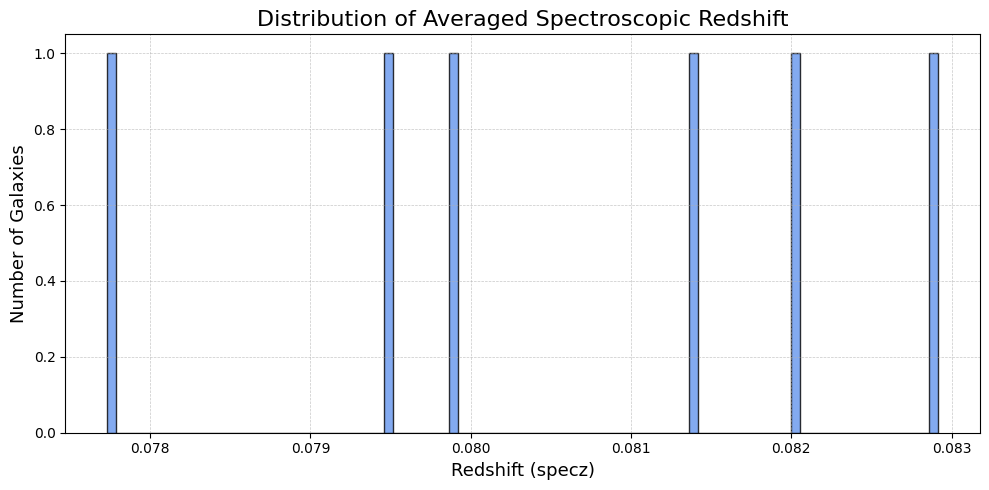

In [24]:
plt.figure(figsize=(10, 5))
plt.hist(averaged_df['specz'], bins=90, color='cornflowerblue', edgecolor='black', alpha=0.8)
plt.title("Distribution of Averaged Spectroscopic Redshift", fontsize=16)
plt.xlabel("Redshift (specz)", fontsize=13)
plt.ylabel("Number of Galaxies", fontsize=13)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Filter your data based on the 3-sigma limit of redshift. You should remove all data points which are 3-sigma away from mean of redshift

In [8]:
# Filtering the data based on specz values, used 3 sigma deviation from mean as upper limit.
filtered_df = averaged_df [( averaged_df['specz'] >= lower_limit) & ( averaged_df['specz'] <= upper_limit )].copy()
print(f"Number of galaxies in the cluster: {len(filtered_df)}")

Number of galaxies in the cluster: 6


Use the relation between redshift and velocity to add a column named velocity in the data. This would tell the expansion velocity at that redshift 

In [9]:
filtered_df['velocity'] = c.value * filtered_df['specz'] 

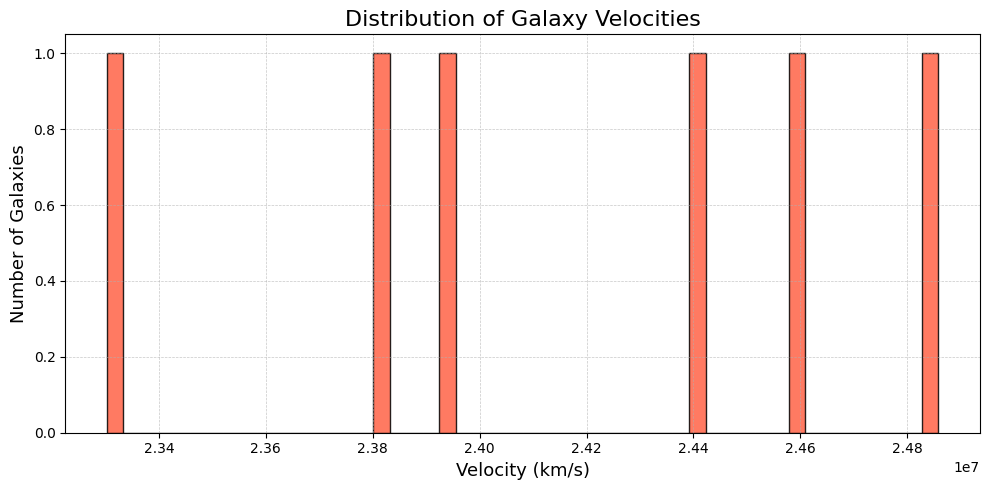

In [26]:
#plot the velocity column created as hist
plt.figure(figsize=(10, 5))
plt.hist(filtered_df['velocity'], bins=50, color='tomato', edgecolor='black', alpha=0.85)
plt.title("Distribution of Galaxy Velocities", fontsize=16)
plt.xlabel("Velocity (km/s)", fontsize=13)
plt.ylabel("Number of Galaxies", fontsize=13)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

use the dispersion equation to find something called velocity dispersion. You can even refer to wikipedia to know about the term [wiki link here](https://en.wikipedia.org/wiki/Velocity_dispersion#:~:text=In%20astronomy%2C%20the%20velocity%20dispersion,%2C%20galaxy%20cluster%2C%20or%20supercluster.)

It is the velocity dispersion value which tells us, some galaxies might be part of even larger groups!!

### Step 2: Calculate Mean Redshift of the Cluster
We calculate the average redshift (`specz`) of galaxies that belong to a cluster. This gives us an estimate of the cluster's systemic redshift.

`cluster_redshift = filtered_df['specz'].mean()`


The velocity dispersion \( v \) of galaxies relative to the cluster mean redshift is computed using the relativistic Doppler formula:

$$
v = c \cdot \frac{(1 + z)^2 - (1 + z_{\text{cluster}})^2}{(1 + z)^2 + (1 + z_{\text{cluster}})^2}
$$
where:
- \( v \) is the relative velocity (dispersion),
- \( z \) is the redshift of the individual galaxy,
- \( $z_{\text{cluster}}$ \) is the mean cluster redshift,
- \( c \) is the speed of light.


In [11]:
cluster_redshift = filtered_df['specz'].mean()

Pro tip: Check what the describe function of pandas does. Does it help to get quick look stats for your column of dispersion??

In [12]:
def relativistic_velocity(z, z_cluster):
    z1 = (1 + z)**2
    z2 = (1 + z_cluster)**2
    return c.value * (z1 - z2) / (z1 + z2)

filtered_df['v_dispersion'] = filtered_df['specz'].apply(lambda z: relativistic_velocity(z, cluster_redshift))
disp = filtered_df['v_dispersion'].std()

In [13]:

print(f"The value of the cluster redshift = {cluster_redshift:.4}")
print(f"The characteristic value of velocity dispersion of the cluster along the line of sight = {disp:.4} km/s.")

The value of the cluster redshift = 0.08058
The characteristic value of velocity dispersion of the cluster along the line of sight = 5.285e+05 km/s.


In [14]:
# Describe gives you count, mean, std, min, max, etc.
print(filtered_df['v_dispersion'].describe())

count         6.000000
mean       -388.047913
std      528504.937052
min     -790585.512930
25%     -276279.918287
50%       17262.047081
75%      363388.386029
max      649096.539018
Name: v_dispersion, dtype: float64


### Step 4: Visualizing Angular Separation of Galaxies
We plot a histogram of the projected (angular) separation of galaxies from the cluster center. This helps us understand the spatial distribution of galaxies within the cluster field.

- The x-axis represents the angular separation (in arcminutes or degrees, depending on units).
- The y-axis shows the number of galaxies at each separation bin.



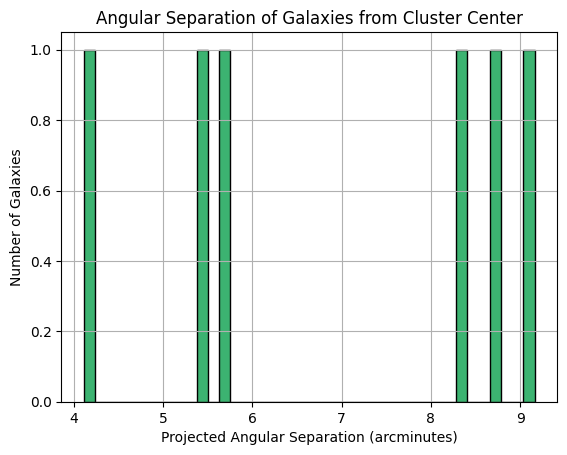

In [15]:
#Plot histogram for proj sep column
plt.hist(filtered_df['proj_sep'], bins=40, color='mediumseagreen', edgecolor='black')
plt.xlabel("Projected Angular Separation (arcminutes)")
plt.ylabel("Number of Galaxies")
plt.title("Angular Separation of Galaxies from Cluster Center")
plt.grid(True)
plt.show()

### Determining size and mass of the cluster:

### Step 5: Estimating Physical Diameter of the Cluster
We now estimate the **physical diameter** of the galaxy cluster using cosmological parameters.

- `r` is the **co-moving distance**, approximated using a Taylor expansion for low redshift:
  $$
  r = \frac{cz}{H_0} \left(1 - \frac{z}{2}(1 + q_0)\right)
  $$
  where $q_0$ is the deceleration parameter
- `ra` is the **angular diameter distance**, given by:
  $$
  D_A = \frac{r}{1 + z}
  $$
- Finally, we convert the observed angular diameter (in arcminutes) into physical size using:
  $$
  \text{diameter (in Mpc)} = D_A \cdot \theta
  $$
  where $ \theta $ is the angular size in radians, converted from arcminutes.

> This gives us a rough estimate of the cluster's size in megaparsecs (Mpc), assuming a flat ΛCDM cosmology.


In [16]:
r = (c.value * cluster_redshift / cosmo.H0.value) * (1 - 0.5 * cluster_redshift * (1 + q0))
ra = r / (1 + cluster_redshift)

theta = filtered_df['proj_sep'].mean() * (np.pi / 180) / 60
diameter =  ra * theta 

diameter #in Mpc

np.float64(653.0483721834189)

### Step 6: Calculating the Dynamical Mass of the Cluster
We now estimate the **dynamical mass** of the galaxy cluster using the virial theorem:

$$
M_{\text{dyn}} = \frac{3 \sigma^2 R}{G}
$$

Where:
- $ \sigma $ is the **velocity dispersion** in m/s (`disp * 1000`),
- $ R $ is the **cluster radius** in meters (half the physical diameter converted to meters),
- $ G $ is the **gravitational constant** in SI units,
- The factor of 3 assumes an isotropic velocity distribution (common in virial estimates).

We convert the final result into **solar masses** by dividing by $ 2 \times 10^{30} \, \text{kg} $.

> This mass estimate assumes the cluster is in dynamical equilibrium and bound by gravity.


In [17]:
### Calculating the dynamical mass in solar masses:
M_dyn =3*((disp*1000)**2)*(diameter*0.5*10**6*3*10**16)/(G*2*10**30)

print(f"Dynamical Mass of the cluster is {M_dyn:.2e} solar mass")

Dynamical Mass of the cluster is 6.15e+22 s2 kg / m3 solar mass
